In [ ]:
!pip install pymoo > install_log

In [ ]:
import numpy as np
import pandas as pd

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold, cross_val_score, train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.ensemble import RandomForestClassifier

import graphviz, joblib, random
import matplotlib.pyplot as plt

import seaborn as sns
import scipy.stats as st

from torch import nn
import torch
from tqdm import tqdm
from xgboost import XGBClassifier
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.soo.nonconvex.pso import PSO
from pymoo.algorithms.soo.nonconvex.cmaes import CMAES
from pymoo.optimize import minimize

from imblearn.over_sampling import SMOTE, SMOTENC, SMOTEN, KMeansSMOTE, BorderlineSMOTE, SVMSMOTE, ADASYN
from imblearn.combine import SMOTEENN, SMOTETomek
from multiprocessing import Process, Queue
import time

import warnings
warnings.filterwarnings('ignore')

In [ ]:
def get_stats(Input):
    metric_results,run_time = Input
    d = np.array(list(metric_results.values()))
    stds = np.std(d,axis=1)
    means = np.mean(d,axis=1)
    return dict(info={name:i for i,name in enumerate(list(metric_results.keys()))},
                mean = means,
                std = stds,
                runTime = run_time
               )
def is_only_categorical_features(categorical_features):
    for i in range(len(categorical_features)):
        if i not in categorical_features: return False
    return True

def worker(id,controler,model_class,model_setting, 
           xtrain,ytrain,encoder, xtest, ytest,
           metric_methods,metric_results,sampler_setting={},
           tracking=False):
    
    start_time = time.time()
    if tracking: print(f"Thread {id} working\n")
    
    # Data argurmentation
    if tracking: print(f"Thread {id} is adding new data\n")
    new_sampler_setting = sampler_setting.copy()
#     new_sampler_setting.pop("categorical_features")
    smote = SMOTE(**new_sampler_setting)
    xtrain,ytrain = smote.fit_resample(xtrain,ytrain)
    
    xtrain,ytrain = xtrain,encoder.transform(ytrain)
    ytest = encoder.transform(ytest)
    
    # Model fitting
    if tracking: print(f"Thread {id} is training model\n")
    if tracking: print(f"Thread {id} \n\tmodel_setting: {model_setting}\n")
    model_eval = model_class(**model_setting)
    model_eval.fit(xtrain,ytrain)
    
    if tracking: print(f"Thread {id} eval done\n")
    y_hat = model_eval.predict(xtest)
    
    if tracking: print(f"Thread {id} add metric results\n")
    for name_metrics, (func,setting) in metric_methods.items():
        metric_results[name_metrics].append(func(ytest,y_hat,**setting))
        
    end_time = time.time()
    controler.put((metric_results,float(end_time-start_time)))
    if tracking: print(f"Thread {id} done \n")
    
def train_and_eval_model_multithread(model,model_setting,features,targets,encoder,sampler_setting={},cv=5,tracking=False,use_feature_select=True, **kwargs):
    start_time = time.time()
    sampler_setting = sampler_setting.copy()
    wokers_list=[]
    kf = KFold(n_splits=cv, shuffle=True)#KFold
    queue = Queue()
    time_ = 0
    metric_results = dict(accuracy=[], precision=[], recall=[], f1=[])    
    metric_methods = dict(accuracy=(accuracy_score,{}), 
                          precision=(precision_score,{"average":"weighted","zero_division":0}), 
                          recall=(recall_score,{"average":"weighted","zero_division":0}), 
                          f1=(f1_score,{"average":"weighted","zero_division":0}))
    # Features selection
    n_selected_features = kwargs["nFS"]["n"]
    selected_features = features.columns.to_list()
    if use_feature_select: 
        selected_features = features.columns.to_list()[:n_selected_features]
    new_features = features[selected_features]
    new_targets = targets
    
    # K-Fold
    for i,(train_index, test_index) in enumerate(kf.split(new_features.values)):
        xtrain,ytrain = new_features.iloc[train_index].values, new_targets[train_index].values            
        xtest,ytest = new_features.iloc[test_index].values, new_targets[test_index].values
        
        process_new = Process(target=worker, args=(i,queue,model,model_setting, xtrain,ytrain,encoder, 
                                                   xtest, ytest,metric_methods,metric_results,sampler_setting,tracking))
        wokers_list.append(process_new)
        wokers_list[i].start()
    
    c=0
    while c<cv:
        if queue.empty() == False:
            c += 1
            temp, time_tmp = queue.get(block=False)
            time_+=time_tmp
            for i in temp.keys():
                metric_results[i].extend(temp[i])
                
    end_time = time.time()
    return metric_results, float(end_time-start_time)+time_

def run_multiTime_KFLOD(n_runs=2, use_tqdm=False, interval=False, **kwargs):
    if interval:
        assert n_runs > 2, f"n_runs must be greater than 1"
    time_run_avg = 0
    bank = {"f1":[],"accuracy":[],"precision":[],"recall":[]}
    bank_all = {"f1":[],"accuracy":[],"precision":[],"recall":[]}
    if use_tqdm:
        for i in tqdm(range(n_runs)):
            model_results = train_and_eval_model_multithread(**kwargs)
            model_stats = get_stats(model_results)
            time_run_avg+=model_stats["runTime"]

            for name, index in model_stats["info"].items():
                bank[name].append(model_stats["mean"][index])
                bank_all[name]+= model_results[0][name]
    else:
        for i in range(n_runs):
            model_results = train_and_eval_model_multithread(**kwargs)
            model_stats = get_stats(model_results)
            time_run_avg+=model_stats["runTime"]

            for name, index in model_stats["info"].items():
                bank[name].append(model_stats["mean"][index])
                bank_all[name]+= model_results[0][name]
                
    stats = get_stats((bank,time_run_avg/n_runs))
    if interval: 
        data = bank["f1"]
        temp = st.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data), scale=st.sem(data))[0]
        return bank, stats, temp
    return bank, stats

In [ ]:
class MyProblem(ElementwiseProblem):

    def __init__(self,X,Y,bounds,rectify,model_class, encoder ,sub_setting={"model":{},"sampler":{}},cv=5,**kwargs):
        
        self.X=X
        self.Y=Y
        self.cv=cv
        self.model_class=model_class
        
        self.model_rectify = rectify["model"]
        self.sampler_rectify = rectify["sampler"]
        self.fcr = rectify["fc"]
        
        self.model_bounds = bounds["model"]
        self.sampler_bounds = bounds["sampler"]
        self.fcb = bounds["fc"]
        
        self.sub_setting_model = sub_setting["model"]
        self.sub_setting_sampler = sub_setting["sampler"]
        
        self.use_feature_select=kwargs["use_feature_select"]
        self.encoder = encoder
        super().__init__(n_var=len(self.model_bounds)+len(self.sampler_bounds)+len(self.fcb),
                         n_obj=1,
                         xl=np.array([i[0] for i in list(self.model_bounds.values())] + 
                                     [i[0] for i in list(self.sampler_bounds.values())]+
                                     [i[0] for i in list(self.fcb.values())]),
                         xu=np.array([i[1] for i in list(self.model_bounds.values())] + 
                                     [i[1] for i in list(self.sampler_bounds.values())]+
                                     [i[1] for i in list(self.fcb.values())]),
                         **kwargs)
        
    def _evaluate(self, x, out, *args, **kwargs):
        model_setting_solution = {}
        sampler_setting_solution = {}
        n_selected_features = {}
        
        model_key = list(self.model_bounds.keys())
        sampler_key = list(self.sampler_bounds.keys())
        fc_key = list(self.fcb.keys())
        
        n = len(self.model_bounds)
        n_s = len(self.sampler_bounds)
        for index,value in enumerate(x):
            if index<n:
                key = model_key[index]
                model_setting_solution.update({key:self.model_rectify[key](value)})
            elif index<n+n_s:
                key = sampler_key[index-n]
                sampler_setting_solution.update({key:self.sampler_rectify[key](value)})
            else:
                key = fc_key[index-n-n_s]
                n_selected_features.update({key:self.fcr[key](value)})
        model = self.model_class

        model_results = run_multiTime_KFLOD(1, model = model, model_setting = {**model_setting_solution,**self.sub_setting_model},
                            features = self.X, targets = self.Y, encoder = self.encoder, cv=self.cv,
                            sampler_setting={**sampler_setting_solution,**self.sub_setting_sampler},
                            nFS = {**n_selected_features}, use_feature_select=self.use_feature_select)
        
        model_stats = model_results[-1]
        r = model_stats
        output = r["mean"][r["info"]["f1"]]

        out["F"] = [-output]
        

def initalize_point(bounds):
    model = bounds["model"]
    sampler = bounds["sampler"]
    fc = bounds["fc"]
    lb = np.array([i[0] for k,i in model.items()]+[i[0] for k,i in sampler.items()]+[i[0] for k,i in fc.items()])
    ub = np.array([i[1] for k,i in model.items()]+[i[1] for k,i in sampler.items()]+[i[1] for k,i in fc.items()])

    x0 = np.random.random(len(model)+len(fc)+len(sampler))
    diff = ub-lb
    x1 = lb + x0*diff
    return x1
    
def find_optimal_hyperparameters(bounds,rectify,model_class,dataset,encoder,pop_size=100,sub_setting=dict(model={},sampler={}),use_feature_select=True):
    print("Set up dataset")
    X,y = dataset
    
    print("Initialize problem")
    problem = MyProblem(X,y,bounds,rectify,model_class,encoder,sub_setting,use_feature_select=use_feature_select)
    
    print("Initialize algorithm")
    algorithm = CMAES(initalize_point(bounds))
    print("Start optimize process")
    res = minimize(problem, algorithm,
                   save_history=True, verbose=True,termination=("n_gen",40))
    
    joblib.dump(res,f"{model_class.__name__}_res.sav")
    
    model_setting_solution = {}
    sampler_setting_solution = {}
    n_selected_features = {}

    model_key = list(bounds["model"].keys())
    sampler_key = list(bounds["sampler"].keys())    
    fs_key = list(bounds["fc"].keys())
    
    n = len(model_key)
    n_s = len(sampler_key)
    for index,value in enumerate(res.X):
        if index<n:
            key = model_key[index]
            model_setting_solution.update({key:rectify["model"][key](value)})
        elif index<n+n_s:
            key = sampler_key[index-n]
            sampler_setting_solution.update({key:rectify["sampler"][key](value)})
        else:
            key = fs_key[index-n-n_s]
            n_selected_features.update({key:rectify["fc"][key](value)})
        
            
    a = {"setting":{"model":{**model_setting_solution,**sub_setting["model"]},
                    "sampler":{**sampler_setting_solution,**sub_setting["sampler"]},
                    "fs":{**n_selected_features}
                   },
            "F":res.F,"res":res}
    print("Best solution found:")
    print(a)
    return a

In [ ]:
def search(model_class,xNew,yNew,
           model_bounds,model_rectify,
           sampler_bounds,sampler_rectify,encoder,
           sub_setting_model={},sub_setting_sampler={},
           global_bank=None,use_feature_select=True,**kwargs):
    
    bounds = dict(
        model=model_bounds,
        sampler= sampler_bounds,
        fc = kwargs["FCB"])

    rectify = dict(
        model = model_rectify,
        sampler = sampler_rectify,
        fc = kwargs["FCR"])
    
    sub_setting = dict(model = sub_setting_model,
                       sampler = sub_setting_sampler)
    
    dataset= (xNew,yNew)
    optimal_setting = find_optimal_hyperparameters(bounds,rectify,model_class,dataset,
                                                   encoder,sub_setting=sub_setting,use_feature_select=use_feature_select)
    
    model_setting = optimal_setting["setting"]["model"]
    sampler_setting = optimal_setting["setting"]["sampler"]    
    fs_setting = optimal_setting["setting"]["fs"]
    
    stats = run_multiTime_KFLOD(31, True, model = model_class, model_setting = model_setting,
                        features = xNew, targets = yNew, encoder = encoder,
                        sampler_setting = sampler_setting, nFS = fs_setting,use_feature_select=use_feature_select)
    stats = stats[-1]
    if global_bank!=None:
        name = kwargs.get("name",model_class.__name__)
        global_bank[name]={
            "stats":stats.copy(),
            "optimal_setting":optimal_setting.copy(),
        }
    return stats

# Load Data

In [ ]:
df = pd.read_csv("/kaggle/input/higher-education-predictors-of-student-retention/dataset.csv")

In [ ]:
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif, f_classif, SelectKBest
from scipy.stats import kendalltau

def make_tau_scores(X, y):
    mi_scores = {"p-value":[],"stats":[]}
    for col in X.columns:
        res = kendalltau(X[col].values, y.values)
        mi_scores["p-value"].append(res.pvalue)        
        mi_scores["stats"].append(res.correlation)
    mi_scores = pd.DataFrame(mi_scores, index=X.columns)
    mi_scores = mi_scores.sort_values("p-value",ascending=True)
    return mi_scores

In [ ]:
encoder = LabelEncoder()
encoder.fit(df["Target"].values.reshape(-1, 1))

In [ ]:
global_bank={}

In [ ]:
# mi_scores = make_tau_scores(df.drop("Target",axis=1), df["Target"])

# mi_scores_df = mi_scores[mi_scores["p-value"]<0.001]
# mi_scores_df = mi_scores_df.sort_values("p-value",ascending=True)

# features_selected = mi_scores_df

# Hyper-parameters Optimizer

## KNN

In [ ]:
# Get features based on Kendal-tau
mi_scores = make_tau_scores(df.drop("Target",axis=1), df["Target"])

mi_scores_df = mi_scores[mi_scores["p-value"]<0.001]
mi_scores_df = mi_scores_df.sort_values("p-value",ascending=True)

features_selected = mi_scores_df

# Get datapoints based on selected features
X = df[features_selected.index.to_list()]
y = df["Target"]

# Config bound and data type of hyper-paparameters of model
model_bounds = dict(n_neighbors=(3,500))
model_rectify = dict(n_neighbors = int )

# Config number of feature
feature_selection_bounds = dict(n=(3,len(features_selected.index.to_list())))
feature_selection_rectify = dict(n=int)

# Config bound and data type of hyper-paparameters of data argumentation algorithm            
sampler_bounds=dict(k_neighbors=(2,150))
sampler_rectify=dict(k_neighbors=int)
           
# Config constant values of hyper-paparameters of data argumentation algorithm and ML algorithm
sub_setting_model = {"weights":"distance"}
sub_setting_sampler = {}

# Config machine learning algorithm  
model_class= KNeighborsClassifier

# Search and save optimal hyper-parameter in global_bank dictionary
search(model_class, X, y,
       model_bounds, model_rectify,
       sampler_bounds, sampler_rectify,encoder,
       sub_setting_model, sub_setting_sampler,
       global_bank, name="KNN",
       FCB=feature_selection_bounds, FCR=feature_selection_rectify, use_feature_select = True)

## Decision Tree

In [ ]:
# Get features based on Kendal-tau
mi_scores = make_tau_scores(df.drop("Target",axis=1), df["Target"])

mi_scores_df = mi_scores[mi_scores["p-value"]<0.001]
mi_scores_df = mi_scores_df.sort_values("p-value",ascending=True)

features_selected = mi_scores_df

# Get datapoints based on selected features
X = df[features_selected.index.to_list()]
y = df["Target"]

# Config bound and data type of hyper-paparameters of model
model_bounds = dict( max_depth=(8,128), min_samples_split=(2,50), 
                       min_samples_leaf=(2,50))

model_rectify = dict( max_depth=int, min_samples_split=int, min_samples_leaf=int)

# Config number of feature
feature_selection_bounds = dict(n=(3,len(features_selected.index.to_list())))
feature_selection_rectify = dict(n=int)

# Config bound and data type of hyper-paparameters of data argumentation algorithm
sampler_bounds=dict(k_neighbors=(2,150))
sampler_rectify=dict(k_neighbors=int)

# Config constant values of hyper-paparameters of data argumentation algorithm and ML algorithm
sub_setting_model = {}
sub_setting_sampler = {}

# Config machine learning algorithm
model_class= DecisionTreeClassifier

# Search and save optimal hyper-parameter in global_bank dictionary
search(model_class, X, y,
       model_bounds, model_rectify,
       sampler_bounds, sampler_rectify,encoder,
       sub_setting_model, sub_setting_sampler,
       global_bank, name="DecisionTree",
       FCB=feature_selection_bounds, FCR=feature_selection_rectify,
       use_feature_select = True)

## Support Vector Machine - kernel: Poly

In [ ]:
# Get features based on Kendal-tau
mi_scores = make_tau_scores(df.drop("Target",axis=1), df["Target"])

mi_scores_df = mi_scores[mi_scores["p-value"]<0.001]
mi_scores_df = mi_scores_df.sort_values("p-value",ascending=True)

features_selected = mi_scores_df

# Get datapoints based on selected features
X = df[features_selected.index.to_list()]
y = df["Target"]

# Config bound and data type of hyper-paparameters of model
model_bounds = dict(C=(0,100),degree=(2,10))
model_rectify = dict(C=float,degree=int)

# Config number of feature
feature_selection_bounds = dict(n=(3,len(features_selected.index.to_list())))
feature_selection_rectify = dict(n=int)

# Config bound and data type of hyper-paparameters of data argumentation algorithm
sampler_bounds=dict(k_neighbors=(2,150))
sampler_rectify=dict(k_neighbors=int)

# Config constant values of hyper-paparameters of data argumentation algorithm and ML algorithm
sub_setting_sampler = {}
sub_setting_model = dict(probability=True,kernel="poly",max_iter=10000)

# Config machine learning algorithm
model_class= SVC

# Search and save optimal hyper-parameter in global_bank dictionary
search(model_class,X, y,
       model_bounds,model_rectify,
       sampler_bounds,sampler_rectify,encoder,
       sub_setting_model, sub_setting_sampler,
       global_bank, name="SVM_Poly",
       FCB=feature_selection_bounds, FCR=feature_selection_rectify, use_feature_select=True)

## Support Vector Machine - kernel: RBF

In [ ]:
# Get features based on Kendal-tau
mi_scores = make_tau_scores(df.drop("Target",axis=1), df["Target"])

mi_scores_df = mi_scores[mi_scores["p-value"]<0.001]
mi_scores_df = mi_scores_df.sort_values("p-value",ascending=True)

features_selected = mi_scores_df

# Get datapoints based on selected features
X = df[features_selected.index.to_list()]
y = df["Target"]

# Config bound and data type of hyper-paparameters of model
model_bounds = dict(C=(0,100),degree=(2,10))
model_rectify = dict(C=float,degree=int)

# Config number of feature
feature_selection_bounds = dict(n=(3,len(features_selected.index.to_list())))
feature_selection_rectify = dict(n=int)

# Config bound and data type of hyper-paparameters of data argumentation algorithm
sampler_bounds=dict(k_neighbors=(2,150))
sampler_rectify=dict(k_neighbors=int)

# Config constant values of hyper-paparameters of data argumentation algorithm and ML algorithm
sub_setting_sampler = {}
sub_setting_model = dict(probability=True,kernel="rbf",max_iter=10000)

# Config machine learning algorithm
model_class= SVC

# Search and save optimal hyper-parameter in global_bank dictionary
search(model_class,X, y,
       model_bounds,model_rectify,
       sampler_bounds,sampler_rectify,encoder,
       sub_setting_model, sub_setting_sampler,
       global_bank, name="SVM_rbf",
       FCB=feature_selection_bounds, FCR=feature_selection_rectify, use_feature_select=True)

## Support Vector Machine - kernel: Linear

In [ ]:
# Get features based on Kendal-tau
mi_scores = make_tau_scores(df.drop("Target",axis=1), df["Target"])

mi_scores_df = mi_scores[mi_scores["p-value"]<0.001]
mi_scores_df = mi_scores_df.sort_values("p-value",ascending=True)

features_selected = mi_scores_df

# Get datapoints based on selected features
X = df[features_selected.index.to_list()]
y = df["Target"]

# Config bound and data type of hyper-paparameters of model
model_bounds = dict(C=(0,2000))
model_rectify = dict(C=float)

# Config number of feature
feature_selection_bounds = dict(n=(3,len(features_selected.index.to_list())))
feature_selection_rectify = dict(n=int)

# Config bound and data type of hyper-paparameters of data argumentation algorithm
sampler_bounds=dict(n_neighbors=(2,150))
sampler_rectify=dict(n_neighbors=int)

# Config constant values of hyper-paparameters of data argumentation algorithm and ML algorithm
sub_setting_sampler = {}
sub_setting_model = dict()

# Config machine learning algorithm
model_class= LinearSVC

# Search and save optimal hyper-parameter in global_bank dictionary
search(model_class, X, y,
       model_bounds, model_rectify,
       sampler_bounds, sampler_rectify,encoder,
       sub_setting_model, sub_setting_sampler,
       global_bank, name="SVM_Linear",
       FCB=feature_selection_bounds, FCR=feature_selection_rectify, 
       use_feature_selection=True)

# Plot results

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

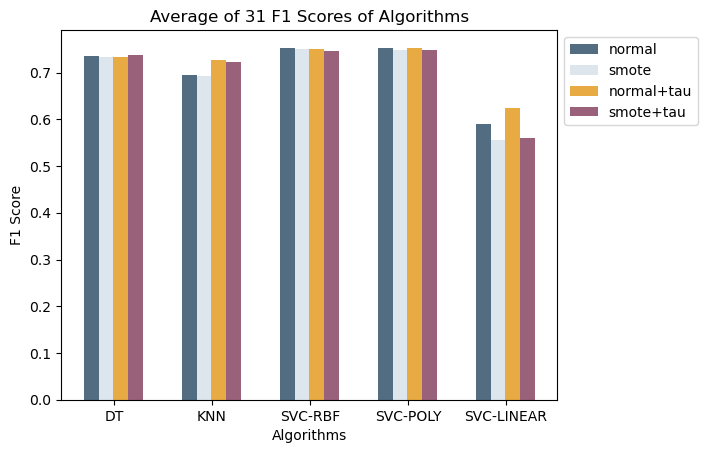

In [2]:
data_f1 = {
    "dt":{
        "normal":0.7358117,
        "smote":0.73294217,
        "normal+tau":0.73346326,
        "smote+tau":0.73797817
    },
    "knn":{
        "normal":0.69557814,
        "smote":0.69192099,
        "normal+tau":0.72622975,
        "smote+tau":0.72259723
    },
    "SVC-rbf":{
        "normal":0.75248168,
        "smote":0.75101009,
        "normal+tau":0.75068102,
        "smote+tau":0.74596062
    },
    "SVC-poly":{
        "normal":0.75294887,
        "smote":0.74865139,
        "normal+tau":0.75315188,
        "smote+tau":0.7481232
    }
    ,
    "SVC-Linear":{
        "normal":0.58941379,
        "smote":0.55603019,
        "normal+tau":0.62385426,
        "smote+tau":0.55968442
    }
}

df = pd.DataFrame(data_f1).T
# df = df.reset_index()

  
N = 5
ind = np.arange(N) 
width = 0.15

cols = df.columns.tolist()

xvals = df[cols[0]].values
bar1 = plt.bar(ind, xvals, width, color = '#526D82')
  
yvals = df[cols[1]].values
bar2 = plt.bar(ind+width, yvals, width, color='#DDE6ED')
  
zvals = df[cols[2]].values
bar3 = plt.bar(ind+width*2, zvals, width, color = '#E8AA42')

zvals = df[cols[3]].values
bar4 = plt.bar(ind+width*3, zvals, width, color = '#99627A')
  
plt.xlabel("Algorithms")
plt.ylabel('F1 Score')
plt.title("Average of 31 F1 Scores of Algorithms")
  
plt.xticks(ind+width+0.08,list(map(lambda x: x.upper(),df.index.tolist())))#['DT', 'KNN', 'SVM-RBF'])
plt.legend( (bar1, bar2, bar3, bar4), ('normal', 'smote', 'normal+tau', 'smote+tau'),
           bbox_to_anchor=(1, 1))
plt.show()

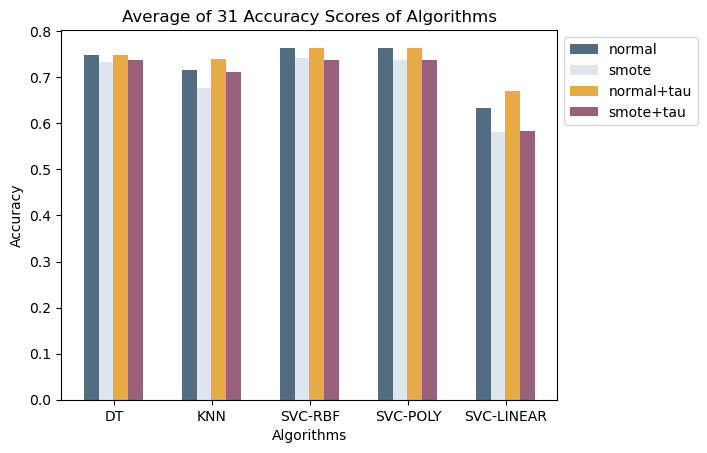

In [3]:
data_acc = {
    "dt":{
        "normal":0.74820674,
        "smote":0.73341903,
        "normal+tau":0.74795108,
        "smote+tau":0.7366271
    },
    "knn":{
        "normal":0.7165684,
        "smote":0.6774624,
        "normal+tau":0.7402292,
        "smote+tau":0.71075679
    },
    "SVC-rbf":{
        "normal":0.76362115,
        "smote":0.74106707,
        "normal+tau":0.76373074,
        "smote+tau":0.7365255
    },
    "SVC-poly":{
        "normal":0.76416036,
        "smote":0.73818,
        "normal+tau":0.7640435,
        "smote+tau":0.73734871
    }
    ,
    "SVC-Linear":{
        "normal":0.63400648,
        "smote":0.5809341,
        "normal+tau":0.6697439,
        "smote+tau":0.58271271
    }
}

df = pd.DataFrame(data_acc).T
# df = df.reset_index()

  
N = 5
ind = np.arange(N) 
width = 0.15

cols = df.columns.tolist()

xvals = df[cols[0]].values
bar1 = plt.bar(ind, xvals, width, color = '#526D82')
  
yvals = df[cols[1]].values
bar2 = plt.bar(ind+width, yvals, width, color='#DDE6ED')
  
zvals = df[cols[2]].values
bar3 = plt.bar(ind+width*2, zvals, width, color = '#E8AA42')

zvals = df[cols[3]].values
bar4 = plt.bar(ind+width*3, zvals, width, color = '#99627A')
  
plt.xlabel("Algorithms")
plt.ylabel('Accuracy')
plt.title("Average of 31 Accuracy Scores of Algorithms")
  
plt.xticks(ind+width+0.08,list(map(lambda x: x.upper(),df.index.tolist())))#['DT', 'KNN', 'SVM-RBF'])
plt.legend( (bar1, bar2, bar3, bar4), ('normal', 'smote', 'normal+tau', 'smote+tau'),
           bbox_to_anchor=(1, 1))
plt.show()